In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tqdm import tqdm

def load_and_preprocess_data(sar_dir, label_dir):
    """
    Load and preprocess SAR and label images based on the reference implementation
    """
    # Get list of files
    sar_files = sorted([f for f in os.listdir(sar_dir) if f.endswith(('.tif', '.png', '.jpg'))])
    label_files = sorted([f for f in os.listdir(label_dir) if f.endswith(('.tif', '.png', '.jpg'))])
    
    image_dataset = []
    mask_dataset = []
    
    print("Loading and preprocessing images...")
    for sar_file, label_file in tqdm(zip(sar_files, label_files)):
        # Load SAR image
        sar_path = os.path.join(sar_dir, sar_file)
        image = cv2.imread(sar_path, -1)  # -1 for unchanged mode
        
        # Load label image
        label_path = os.path.join(label_dir, label_file)
        mask = cv2.imread(label_path, -1)
        
        # Verify images were loaded successfully and have correct size
        if image is None or mask is None:
            print(f"Warning: Could not load {sar_file} or {label_file}")
            continue
            
        if image.shape[:2] != (128, 128) or mask.shape[:2] != (128, 128):
            print(f"Warning: Unexpected image size in {sar_file} or {label_file}")
            continue
        
        # Ensure SAR image is single channel
        if len(image.shape) > 2:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Add to datasets
        image_dataset.append(image)
        mask_dataset.append(mask)
    
    # Convert to numpy arrays
    image_dataset = np.array(image_dataset)
    mask_dataset = np.array(mask_dataset)
    
    
    print(f"\nLoaded {len(image_dataset)} image pairs successfully")
    print(f"SAR array shape: {image_dataset.shape}")
    print(f"Label array shape: {mask_dataset.shape}")

    
    return image_dataset, mask_dataset

# Usage example:
image_dataset, mask_dataset = load_and_preprocess_data(
     sar_dir='/kaggle/input/sample-data-openearthmap/sar_sample (1)',
     label_dir='/kaggle/input/sample-data-openearthmap/label_sample (1)'
 )

Loading and preprocessing images...


5000it [00:55, 90.82it/s] 


Loaded 5000 image pairs successfully
SAR array shape: (5000, 128, 128)
Label array shape: (5000, 128, 128)


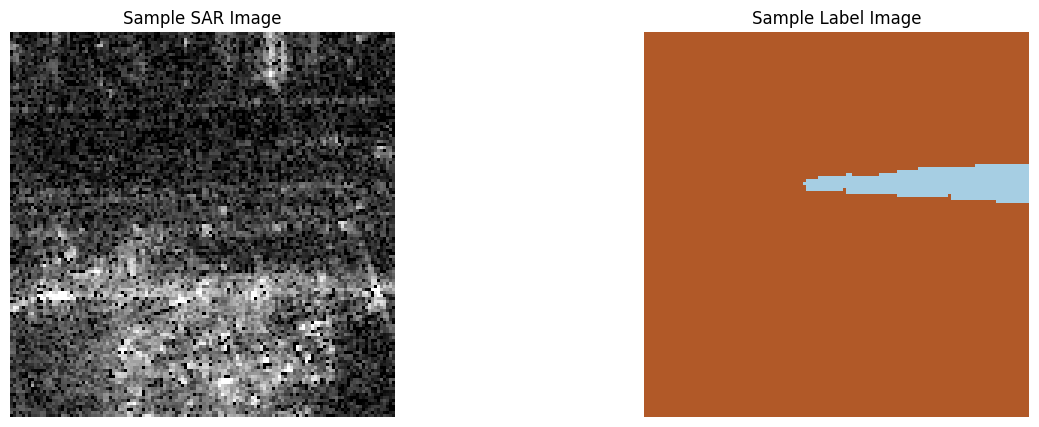

In [2]:
# Display sample images
index = np.random.randint(1080, len(image_dataset))
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_dataset[index].squeeze(), cmap='gray')
plt.title('Sample SAR Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(mask_dataset[index], cmap='Paired')
plt.title('Sample Label Image')
plt.axis('off')
plt.show()

In [3]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [4]:
def merge_classes(mask_image):
    mask_image_copy = mask_image.copy()

    # Define mapping based on merging rules
    merge_class_map = {
        2: 1, 
        4: 3, 
        7: 1,  
        8: 3
    }

    # Apply the merging
    for original_class, new_class in merge_class_map.items():
        mask_image_copy[np.where(mask_image_copy == original_class)] = new_class

    # Define final relabeling to align with target_class_dict
    final_relabel_map = {
        1: 0,  # Bareland
        3: 1,  # Builtup
        5: 2,  # Tree
        6: 3,  # Water
    }

    # Apply the final relabeling
    for original_label, new_label in final_relabel_map.items():
        mask_image_copy[np.where(mask_image_copy == original_label)] = new_label

    return mask_image_copy


In [5]:
labels_dataset = []
for i in range(mask_dataset.shape[0]):
        merged_mask = merge_classes(mask_dataset[i])
        labels_dataset.append(merged_mask)
labels_dataset = np.array(labels_dataset)
print(f"Labels shape:", labels_dataset.shape)

Labels shape: (5000, 128, 128)


In [6]:
#before_Bareland2 = len(np.where(mask_dataset.flatten()==0)[0])
before_Bareland = len(np.where(mask_dataset.flatten()==1)[0])
before_Rangland =   len(np.where(mask_dataset.flatten()==2)[0])
before_Developed_Space =   len(np.where(mask_dataset.flatten()==3)[0])
before_Road =   len(np.where(mask_dataset.flatten()==4)[0])
before_Tree =   len(np.where(mask_dataset.flatten()==5)[0])
before_Water =   len(np.where(mask_dataset.flatten()==6)[0])
before_Agriculture_Land =   len(np.where(mask_dataset.flatten()==7)[0])
before_Building =   len(np.where(mask_dataset.flatten()==8)[0])

after_Water =   len(np.where(labels_dataset.flatten()==3)[0])
after_Tree =   len(np.where(labels_dataset.flatten()==2)[0])
after_Bareland =   len(np.where(labels_dataset.flatten()==0)[0])
after_Builtup =   len(np.where(labels_dataset.flatten()==1)[0])

assert (before_Road+before_Building+before_Developed_Space) == after_Builtup, "Builtup does not match"
assert (before_Rangland+before_Bareland+before_Agriculture_Land) == after_Bareland, "Bareland does not match"
assert before_Tree == after_Tree, "Trees does not match"
assert before_Water == after_Water, "Water does not match"
print(' Merge Validation Passed')
print(' Water = ', np.round(after_Water/(labels_dataset.flatten().shape[0]), 3),
                        ' Trees = ', np.round(after_Tree/(labels_dataset.flatten().shape[0]), 3),
                        ' Bareland = ', np.round(after_Bareland/(labels_dataset.flatten().shape[0]), 3),
                        ' Builtup = ', np.round(after_Builtup/(labels_dataset.flatten().shape[0]), 3))

 Merge Validation Passed
 Water =  0.107  Trees =  0.14  Bareland =  0.336  Builtup =  0.417


In [7]:
n_classes = 4

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

def pyramid_pooling_block(x, bin_sizes):
    """Pyramid Pooling Module using Keras layers"""
    pool_outputs = []
    h, w = x.shape[1:3]
    
    for bin_size in bin_sizes:
        pool_size = (h // bin_size, w // bin_size)
        pool = AveragePooling2D(pool_size=pool_size, strides=pool_size)(x)
        conv = Conv2D(128, 1, padding='same', activation='relu')(pool)
        up = UpSampling2D(size=pool_size, interpolation='bilinear')(conv)
        pool_outputs.append(up)
    
    return Concatenate()([x] + pool_outputs)

def build_lightweight_pspnet(input_size, n_classes):
    """Build lightweight PSPNet model"""
    inputs = Input(shape=input_size)
    
    # Encoder
    x = Conv2D(64, 3, padding='same', activation='relu')(inputs)
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    c1 = MaxPooling2D()(x)
    
    x = Conv2D(128, 3, padding='same', activation='relu')(c1)
    x = Conv2D(128, 3, padding='same', activation='relu')(x)
    c2 = MaxPooling2D()(x)
    
    x = Conv2D(256, 3, padding='same', activation='relu')(c2)
    x = Conv2D(256, 3, padding='same', activation='relu')(x)
    c3 = MaxPooling2D()(x)
    
    # Pyramid Pooling Module
    ppm = pyramid_pooling_block(c3, bin_sizes=[1, 2, 4, 8])
    
    # Decoder
    x = Conv2D(256, 3, padding='same', activation='relu')(ppm)
    x = UpSampling2D()(x)
    x = Conv2D(128, 3, padding='same', activation='relu')(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    x = UpSampling2D()(x)
    
    outputs = Conv2D(n_classes, 1, padding='same', activation='softmax')(x)
    
    return Model(inputs, outputs)

# Usage
input_shape = (128, 128, 1)
n_classes = 4
# model = build_lightweight_pspnet(input_shape, n_classes)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

X = image_dataset[..., np.newaxis]  # Add channel dimension
y = to_categorical(labels_dataset, num_classes=4)

# Split data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

input_shape = (128, 128, 1)
n_classes = 4
model = build_lightweight_pspnet(input_shape, n_classes)

callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    batch_size = 32,
                    # verbose=12,
                    epochs=40,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    # class_weight=class_weights,
                    callbacks=[callback])
# print("Shape of up2 before concatenation:", tf.keras.backend.int_shape(up2))
# print("Shape of conv2:", tf.keras.backend.int_shape(conv2))


Epoch 1/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 127ms/step - accuracy: 0.3940 - loss: 1.8907 - val_accuracy: 0.4287 - val_loss: 1.2981 - learning_rate: 0.0010
Epoch 2/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.4488 - loss: 1.2194 - val_accuracy: 0.4357 - val_loss: 1.1782 - learning_rate: 0.0010
Epoch 3/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.4544 - loss: 1.1599 - val_accuracy: 0.4367 - val_loss: 1.1714 - learning_rate: 0.0010
Epoch 4/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.4586 - loss: 1.1481 - val_accuracy: 0.4370 - val_loss: 1.1620 - learning_rate: 0.0010
Epoch 5/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.4592 - loss: 1.1540 - val_accuracy: 0.4452 - val_loss: 1.0855 - learning_rate: 0.0010
Epoch 6/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.4925 - loss: 1.1171 - val_accuracy: 0.4238 - val_loss: 1.1467 - learning_rate: 0.0010
Epoch 7/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.5587 - loss: 

In [10]:
import tensorflow as tf

model = tf.keras.models.load_model("/kaggle/input/unet_pspnet_openearthsar_models/keras/default/1/pspnet_openearth_sar (1).keras")

In [11]:
code_label ={'Bareland':0, 'Builtup':1, 'Tree':2, 'Water':3}

In [12]:
def count_class(flat_pixels, code_label):
    after_Water =   len(np.where(flat_pixels==code_label['Water'])[0])
    after_Bareland =   len(np.where(flat_pixels==code_label['Bareland'])[0])
    after_Tree =   len(np.where(flat_pixels==code_label['Tree'])[0])
    after_Builtup =   len(np.where(flat_pixels==code_label['Builtup'])[0])
    print(' Water = ', np.round(after_Water/(flat_pixels.shape[0]), 3),
                            ' Tree = ', np.round(after_Tree/(flat_pixels.shape[0]), 3),
                            ' Bareland = ', np.round(after_Bareland/(flat_pixels.shape[0]), 3),
                            ' Builtup = ', np.round(after_Builtup/(flat_pixels.shape[0]), 3))

In [13]:
# Split data
from sklearn.model_selection import train_test_split
X_train2, X_val2, y_train2, y_val2 = train_test_split(image_dataset, labels_dataset, test_size=0.2, random_state=42)

In [14]:
import numpy as np

def compute_class_wise_iou(y_true, y_pred, class_names):
    iou_dict = {}
    num_classes = len(class_names)
    total_pixels = np.prod(y_true.shape)  # Total number of pixels
    weights = []  # List to store weights for each class
    iou_list = []  # List to store IoU values for weighted IoU and mean IoU

    for cls_idx, cls_name in enumerate(class_names):
        # Create binary masks for the current class
        true_mask = (y_true == cls_idx)
        pred_mask = (y_pred == cls_idx)

        # Compute intersection and union
        intersection = np.logical_and(true_mask, pred_mask).sum()
        union = np.logical_or(true_mask, pred_mask).sum()

        # Avoid division by zero
        if union == 0:
            iou = float('nan')  # Or you can assign 0
        else:
            iou = intersection / union

        iou_dict[cls_name] = iou
        iou_list.append(iou)

        # Compute weights based on the number of pixels in ground truth
        weights.append(true_mask.sum())

    # Normalize weights
    weights = np.array(weights) / total_pixels

    # Calculate mean IoU and weighted IoU
    mean_iou = np.nanmean(iou_list)
    weighted_iou = np.nansum(np.array(iou_list) * weights)

    # Combine all results into a dictionary
    iou_dict['mean_iou'] = mean_iou
    iou_dict["weighted_iou"] = weighted_iou

    return iou_dict

In [15]:
full_map_predictions = model.predict(X_val2)
print(full_map_predictions.shape)
full_map_reshape = np.argmax(full_map_predictions, axis=-1).flatten()

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
(1000, 128, 128, 4)


In [16]:
import os
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support

from matplotlib import pyplot as plt
import random

from tensorflow.keras.utils import to_categorical
import seaborn as sns

In [17]:
report=classification_report(y_val2.flatten(), full_map_reshape, target_names=code_label.keys(), output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
Bareland,0.545065,0.615662,0.578217,5.497544e+06
Builtup,0.660734,0.794683,0.721545,6.607427e+06
Tree,0.433985,0.241482,0.310303,2.471001e+06
Water,0.963084,0.454127,0.617216,1.808028e+06
accuracy,0.613600,0.613600,0.613600,6.135997e-01
macro avg,0.650717,0.526489,0.556820,1.638400e+07
weighted avg,0.621090,0.613600,0.599916,1.638400e+07


In [18]:
pd.DataFrame.from_dict( compute_class_wise_iou(y_val2.flatten(), full_map_reshape, code_label.keys()), orient='index', columns=['IoU'])

,IoU
Bareland,0.406684
Builtup,0.564388
Tree,0.183644
Water,0.446357
mean_iou,0.400268
weighted_iou,0.441023


In [19]:
y_true=y_val2.flatten()
y_pred=full_map_reshape

In [20]:
# 1. Overall Metrics
print("\n=== Overall Metrics ===")
accuracy = np.mean(y_pred == y_true)
print(f"Overall Accuracy: {accuracy:.4f}")

# Calculate Mean IoU
def compute_iou(y_true, y_pred, class_id):
    intersection = np.sum((y_true == class_id) & (y_pred == class_id))
    union = np.sum((y_true == class_id) | (y_pred == class_id))
    return intersection / union if union > 0 else 0

class_names = ['Bareland', 'Builtup', 'Tree', 'Water']
ious = [compute_iou(y_true, y_pred, i) for i in range(len(class_names))]
mean_iou = np.mean(ious)
print(f"Mean IoU: {mean_iou:.4f}")


=== Overall Metrics ===
Overall Accuracy: 0.6136
Mean IoU: 0.4003


In [21]:
# 3. Model Complexity
print("\n=== Model Complexity ===")
total_params = model.count_params()
trainable_params = np.sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"Total Parameters: {total_params/1e6:.2f}M")
print(f"Trainable Parameters: {trainable_params/1e6:.2f}M")


=== Model Complexity ===
Total Parameters: 3.41M
Trainable Parameters: 3.41M


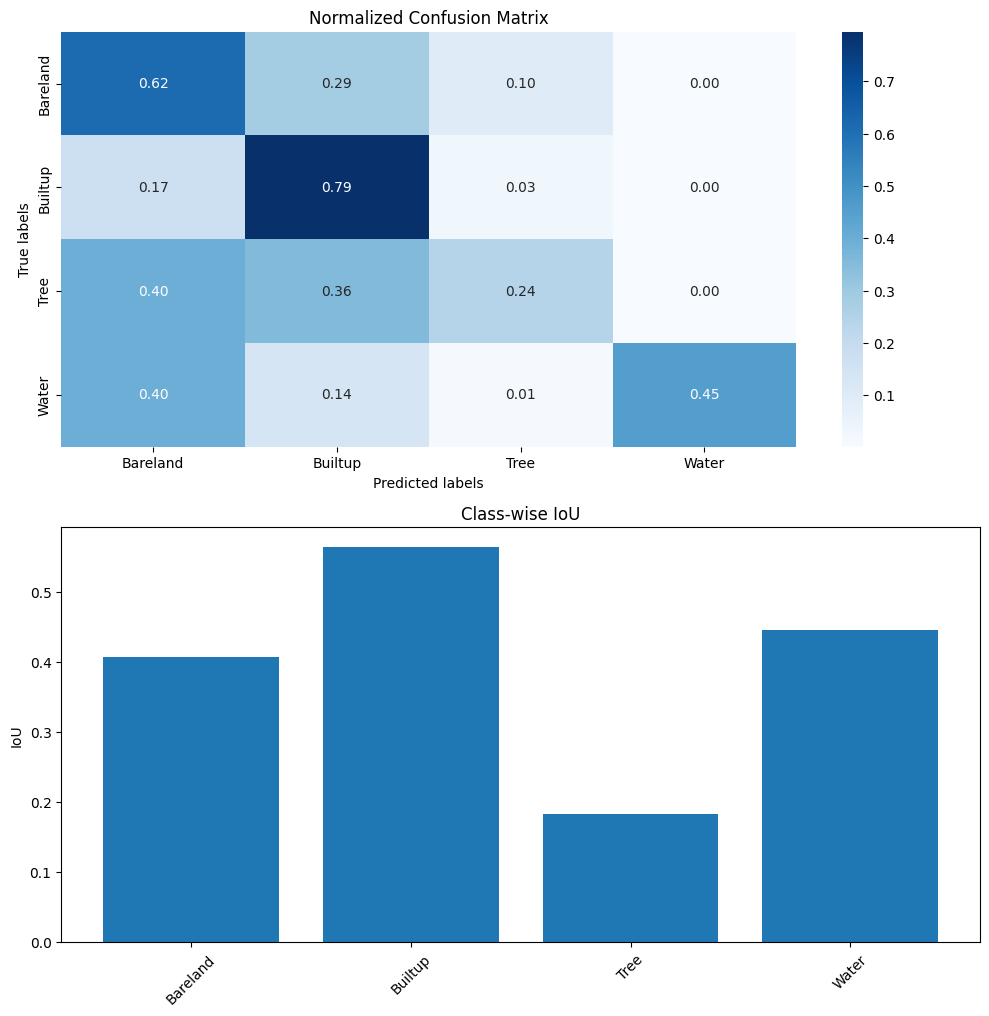

In [22]:
plt.figure(figsize=(10, 15))  # Adjust figure size for vertical layout

# Plot 1: Training History  (already shown in the documentation and this time we have loaded the model so there is no history)
# plt.subplot(3, 1, 1)  # 3 rows, 1 column, first plot
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Val Loss')
# plt.title('Training History')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# Plot 2: Confusion Matrix

plt.subplot(3, 1, 2)  # 3 rows, 1 column, second plot
conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix_norm, 
            annot=True, 
            fmt='.2f',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Normalized Confusion Matrix')

# Plot 3: Class-wise IoU
plt.subplot(3, 1, 3)  # 3 rows, 1 column, third plot
plt.bar(class_names, ious)
plt.title('Class-wise IoU')
plt.xticks(rotation=45)
plt.ylabel('IoU')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [23]:
import time
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
import tensorflow as tf
from scipy import stats

In [24]:
# Calculate FLOPS
def get_flops():
    concrete_func = tf.function(lambda x: model(x)).get_concrete_function(
        tf.TensorSpec([1, 128, 128, 1], model.inputs[0].dtype))
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph_def = frozen_func.graph.as_graph_def()
    
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd="op", options=opts)
    return flops.total_float_ops

# Calculate Speed (FPS)
def measure_fps():
    # Warmup
    for i in range(10):
        _ = model.predict(np.zeros((1, 128, 128, 1)))
        
    # Measure time for 100 predictions
    start_time = time.time()
    num_predictions = 100
    for i in range(num_predictions):
        _ = model.predict(np.zeros((1, 128, 128, 1)))
    end_time = time.time()
    
    fps = num_predictions / (end_time - start_time)
    return fps

# Print Model Performance Stats
print("\n=== Model Performance Statistics ===")
flops = get_flops()
print(f"FLOPS: {flops/1e9:.2f} GFLOPs")

fps = measure_fps()
print(f"Speed: {fps:.2f} FPS")


=== Model Performance Statistics ===
FLOPS: 6.99 GFLOPs
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/